# EDA

## Import Libraries

In [12]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv


import model.train as train
import model.config as config
import utils as utils
import model.dataset.game_matchup as ds_games_matchup
from pandas_profiling import ProfileReport
from yellowbrick.target import FeatureCorrelation
import qgrid

## Setup

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set(style='whitegrid', palette=sns.color_palette(
    "BuGn_r"), font_scale=1.5, color_codes=True)

#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_columns", 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Utils functions

In [14]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

## Load dataset

Este dataset consiste en un matchup report de la situacion de cada equipo previo a cada partido. Fue creado a partir del historico de partidos de la NBA, obtenido de [kaggle-nba-games](https://www.kaggle.com/nathanlauga/nba-games).

Nomenclatura utilizada en las columnas del dataset:

Prefijos que indican si los datos corresponde al equipo casa o visitante:

- HT: Home Team
- VT: Visitor Team

Sufijos que hacen referencia a la estadistica de cada equipo cuando juega en casa o como visitante:

- \_H: Home. Ej: HT_HW, este campo representa la cantidad de partidos ganados en casa por el equipo que es HOME para ese partido.
- \_V: Visitor. Ej: VT_VL, este campo representa la cantidad de partidos perdidos como visitante por el equipo que es VISITOR para ese partido.

Letras significados:

- W: Win, o victorias.
- L: Lost, o derrotas.

Columnas "\_OVERALL\_":

Estas columnas representa los promedios ofensivos y defensivos de cada equipo en cada apartado estadistico(puntos, rebotes, FG, 3FG, FT, REB). Este promedio se calcula de la siguiente forma:

- Se realiza por temporada. Solo se considera la temporada actual para cada una de estos datos. Por lo que los primero partidos suelen tener muy poca informacion.

Nota:

Se considero en un momento utilizar esta opcion.

- Pero para los primeros 10 se utilizan los datos de la temporada anterior, adicional con los partidos hasta la fecha de esa temporada.
- A partir de los 10 primero partidos pues se calculan estos promedios considerando unicamente los partidos de la temporada.

Este dataset se compone de 70 columnas, de las cuales las mas destacadas son:

Sobre el partido:

- GAME_ID, GAME_DATE_EST, SEASON, HOME_TEAM_WINS

El resto de columnas, 66, esta divido entre la mitad hacen referencia a datos del equipo casa y la otra midad al equipo visitante.

- HT_RANK: Es la posicion en el standing de toda la liga del equipo casa para ese partido. Nota: Este ranking esta ordenado desde el peor equipo hasta el mejor, de forma ascendente, es decir:
    Los bucks que consiguieron el mejor record de la temporada 2018-2019, estan en el ranking 29, y los Knicks que fueron el peor equipo estan en el ranking 0.
- HT_CLASS: Es una especie de categoria a la que pertenece el equipo, basado en su posicion en el ranking. Si el equipo esta en un raking >= 20 pertenece a la clase 2, >= 10 pertenece a la clase 1 y <10 pertenece a la clase 0.

Para el equipo casa estos features representan:

- Datos de la temporada actual:

    - HT_HW: cantidad de victorias en casa.
    - HT_HL: cantidad de derrotas en casa.
    - HT_VW: cantidad de victorias como visitante.
    - HT_VL: cantidad de derrotas.
    - HT_OVERALL_OFF_POINTS: promedio ofensivo de puntos.
    - HT_OVERALL_DEF_POINTS: promedio defensivo de puntos.
    - HT_OVERALL_OFF_FG: promedio ofensivo de Field Goal.
    - HT_OVERALL_DEF_FG: promedio defensivo de Field Goal.
    - HT_OVERALL_OFF_3P: promedio ofensivo de Field Goal de tiros de 3.
    - HT_OVERALL_DEF_3P: promedio defensivo de Field Goal de tiros de 3.
    - HT_OVERALL_OFF_FT: promedio ofensivo de tiros libres.
    - HT_OVERALL_DEF_FT: promedio defensivo de tiros libres.
    - HT_OVERALL_OFF_REB: promedio ofensivo de rebotes.
    - HT_OVERALL_DEF_REB: promedio defensivo de rebotes.

    - Datos del equipo pero como visitante

        - HT_AWAY_POINTS: promedio de puntos
        - HT_AWAY_FG: promedio de field goal
        - HT_AWAY_3P: promedio de field goal de tiros de 3.
        - HT_AWAY_FT: promedio de tiros libres.
        - HT_AWAY_REB: promedio de rebotes.

    - Ultimos 10 partidos
        - HT_LAST10_W: Representa el conteo de victorias de los ultimos 10 partidos del
        - HT_LAST10_L

Ultimos 10 partidos entre el equipo casa y visitante tomando en cuenta todas las temporadas.


    - HT_LAST10_MATCHUP_W
    - HT_LAST10_MATCHUP_L

In [15]:
dataset = ds_games_matchup.load_game_matchup_dataset()

In [16]:
#df = dataset[config.X_columns + config.y_columns]
df = dataset

In [17]:
print(len(df))
seasons = df.SEASON.unique()[-10:]
seasons

19398


array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

Trabajaremos solo con las ultimas 10 temporadas

In [18]:
df = df[df.SEASON.isin(seasons)]

In [21]:
df_09 = df = df[df.SEASON.isin([2009])]

In [22]:
df_09

GAME_DATE_EST HOME_TEAM_NAME  HOME_TEAM_ID VISITOR_TEAM_NAME  \
GAME_ID                                                                 
20900001    2009-10-27            CLE    1610612739               BOS   
20900002    2009-10-27            DAL    1610612742               WAS   
20900003    2009-10-27            POR    1610612757               HOU   
20900004    2009-10-27            LAL    1610612747               LAC   
20900005    2009-10-28            ATL    1610612737               IND   
...                ...            ...           ...               ...   
20901226    2010-04-14            TOR    1610612761               NYK   
20901227    2010-04-14            WAS    1610612764               IND   
20901228    2010-04-14            LAC    1610612746               LAL   
20901229    2010-04-14            POR    1610612757               GSW   
20901230    2010-04-14            UTA    1610612762               PHX   

          VISITOR_TEAM_ID  SEASON  HT_RANK  HT_CLASS  HT_HW  HT_HL  HT_VW  \
GAME_ID                                                                     
20900001       1610612738    2009        8         0      0      0      0   
20900002       1610612764    2009       15         1      0      0      0   
20900003       1610612745    2009       29         2      0      0      0   
20900004       1610612746    2009       26         2      0      0      0   
20900005       1610612754    2009       23         2      0      0      0   
...                   ...     ...      ...       ...    ...    ...    ...   
20901226       1610612752    2009       11         1     24     16     15   
20901227       1610612754    2009        3         0     14     26     11   
20901228       1610612747    2009        7         0     20     20      8   
20901229       1610612744    2009       19         1     26     14     24   
20901230       1610612756    2009       24         2     32      8     21   

          HT_VL  HT_LAST10_W  HT_LAST10_L  HT_LAST10_MATCHUP_W  \
GAME_ID                                                          
20900001      0            0            0                    5   
20900002      0            0            0                    7   
20900003      0            0            0                    2   
20900004      0            0            0                    8   
20900005      0            0            0                    5   
...         ...          ...          ...                  ...   
20901226     26            4            6                    7   
20901227     30            4            6                    3   
20901228     33            2            8                    1   
20901229     17            8            2                    5   
20901230     20            7            3                    6   

          HT_LAST10_MATCHUP_L  HT_OVERALL_OFF_POINTS  HT_OVERALL_DEF_POINTS  \
GAME_ID                                                                       
20900001                    5                  0.000                  0.000   
20900002                    3                  0.000                  0.000   
20900003                    8                  0.000                  0.000   
20900004                    2                  0.000                  0.000   
20900005                    5                  0.000                  0.000   
...                       ...                    ...                    ...   
20901226                    3                103.741                105.765   
20901227                    7                 96.222                101.074   
20901228                    9                 95.580                102.210   
20901229                    5                 97.889                 94.469   
20901230                    4                104.457                 98.877   

          HT_OVERALL_OFF_FG  HT_OVERALL_DEF_FG  HT_OVERALL_OFF_3P  \
GAME_ID                                                             
20900001              0.000     

## Checking null value

In [ ]:
df.isnull().sum().sum()

Se observa que no existen valores nulos.

## Unique enteries in each of the columns

In [ ]:
df.nunique()

## Select features to explore

Previo a explorar nuestro dataset vamos a descartar los siguientes features que de por si entendemos que son redudantes y no lo deseamos en nuestro dataset final a ser usado para entrenar nuestro modelo.

In [ ]:
df_copy = df

In [ ]:
df = df[config.X_columns + config.y_columns]

## Features  correlations

### Utils functions

In [ ]:
def plot_heatmap(data, title):
    mask = np.zeros_like(pearson_corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize = (30, 24))
        heatmap = sns.heatmap(data, mask=mask, square=True,
                        linewidth=1,
                        annot=True,
                        annot_kws={'size' : 10} 
                        )
#     plt.figure(figsize = (30, 24))
#     heatmap = sns.heatmap(data,
#             linewidth=1,
#             annot=True,
#             annot_kws={'size' : 10} )
    plt.title(title, fontsize=25)
    plt.show()
    return heatmap

def save_heatmap(heatmap, name):
    figure = heatmap.get_figure()    
    figure.savefig(f'plots/{name}.png')
    
def top_corr_features(corr):
    c = corr.abs()
    sol = (c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
    return pd.DataFrame(sol)

### Generate correlation matrix

In [20]:
pearson_corr = df.corr(method='pearson')
spearman_corr = df.corr(method='spearman')
kendall_corr = df.corr(method='kendall')

### Pearson Correlations

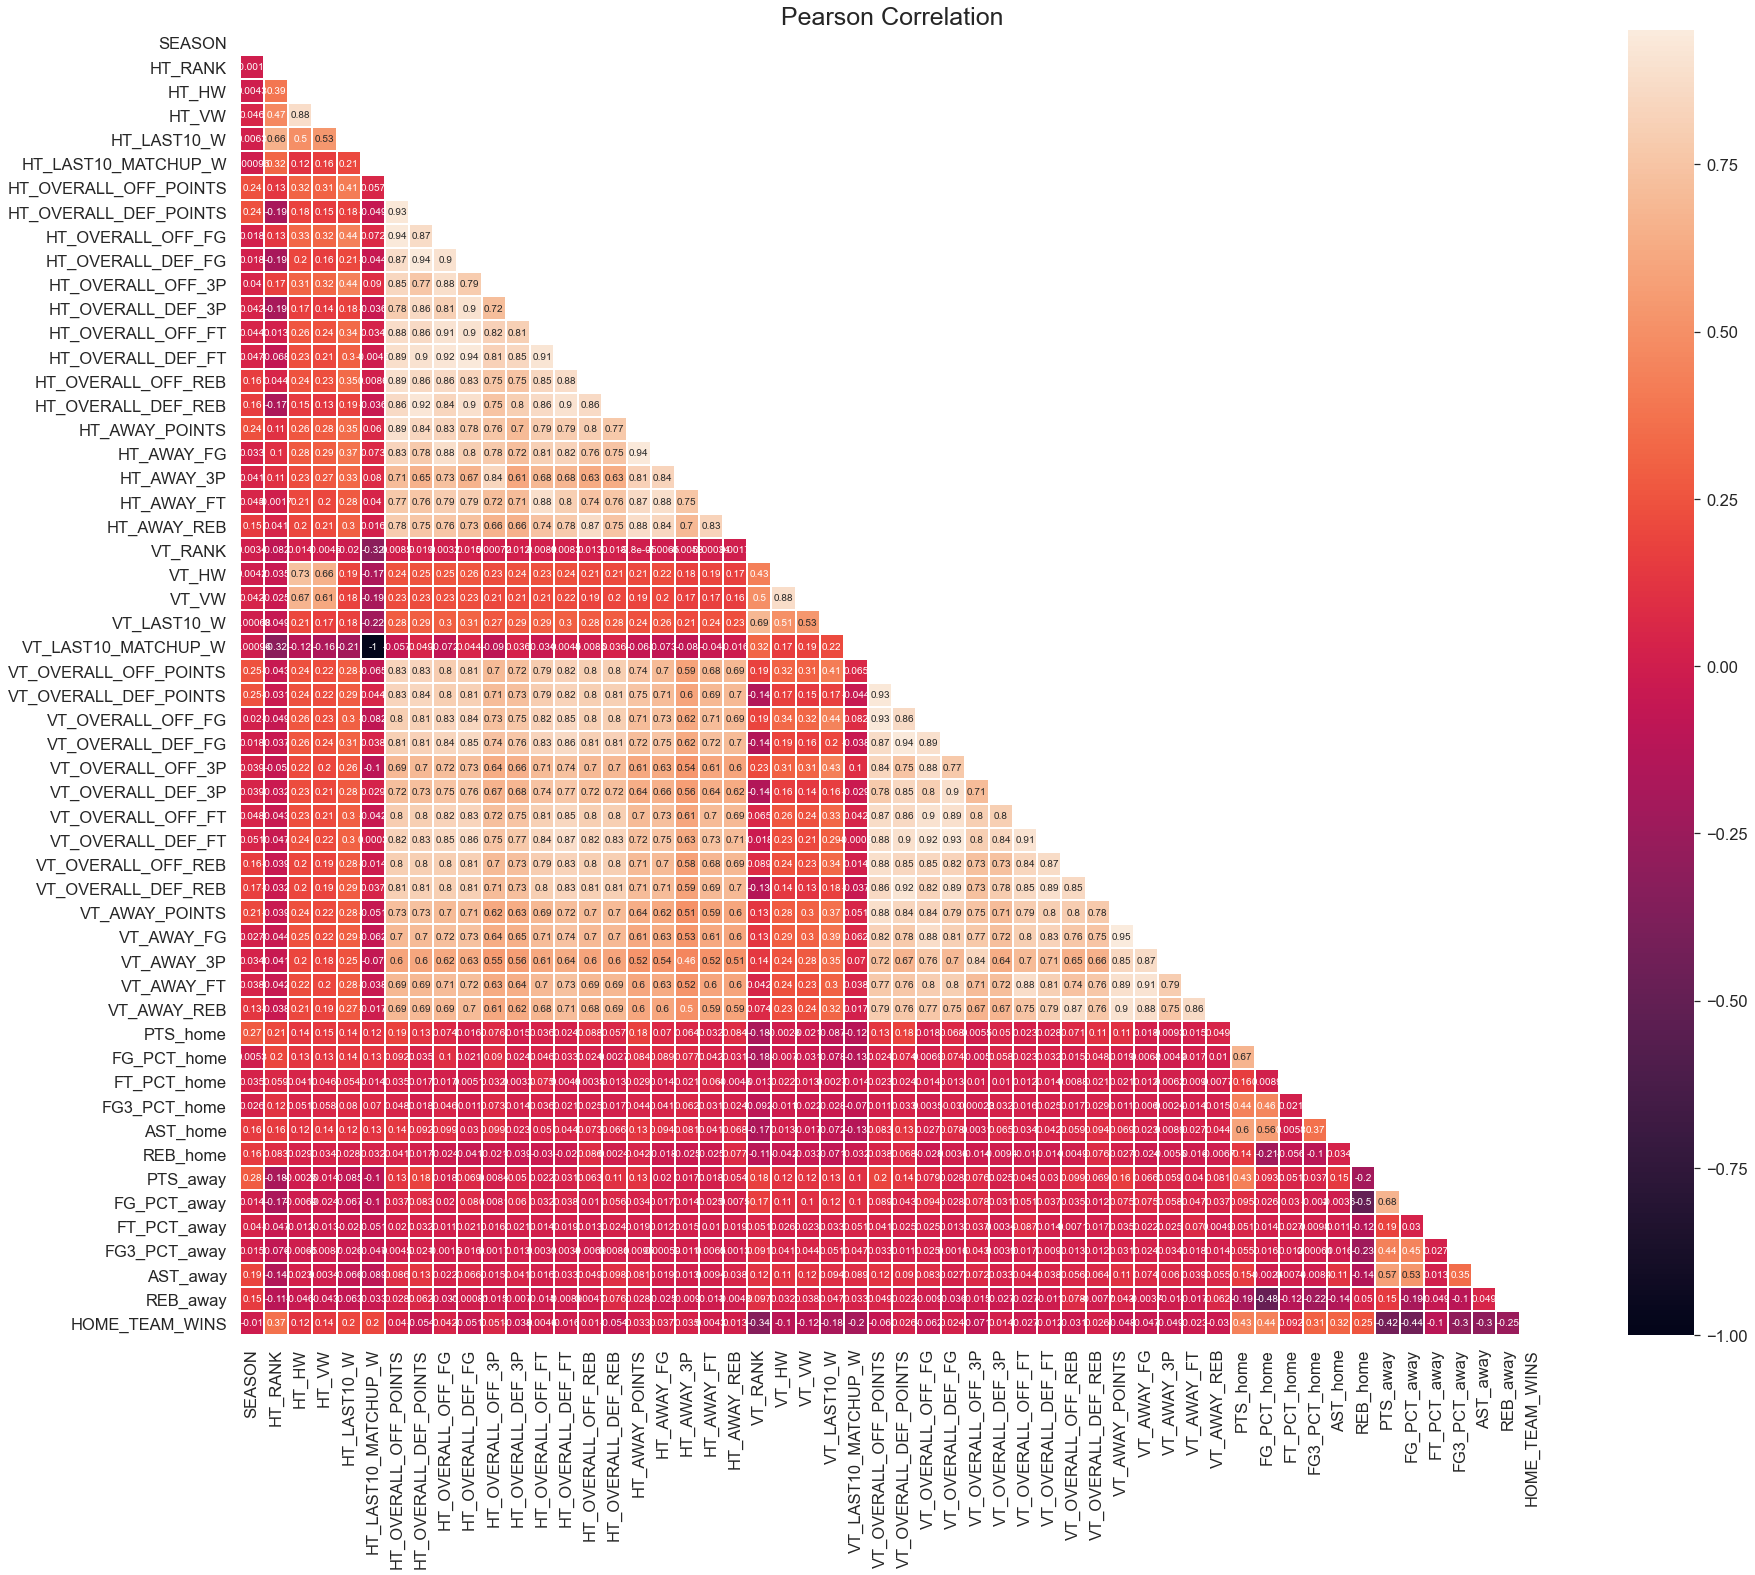

In [21]:
save_heatmap(plot_heatmap(pearson_corr, "Pearson Correlation"), "pearson_corr")
# mask = np.zeros_like(pearson_corr)
# mask[np.triu_indices_from(mask)] = True
# with sns.axes_style("white"):
#     f, ax = plt.subplots(figsize = (30, 24))
#     ax = sns.heatmap(pearson_corr, mask=mask, square=True,
#                     linewidth=1,
#                     annot=True,
#                     annot_kws={'size' : 10} 
#                     )

In [22]:
top_corr_features_df = top_corr_features(pearson_corr)
qgrid_widget = qgrid.show_grid(top_corr_features_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

Se observa que existe muchos features altamente correlacionados, por lo que se evaluara que tan insprecindible son y como es el comportamiento de los experimentos al eliminar estos.

### Spearman Correlation

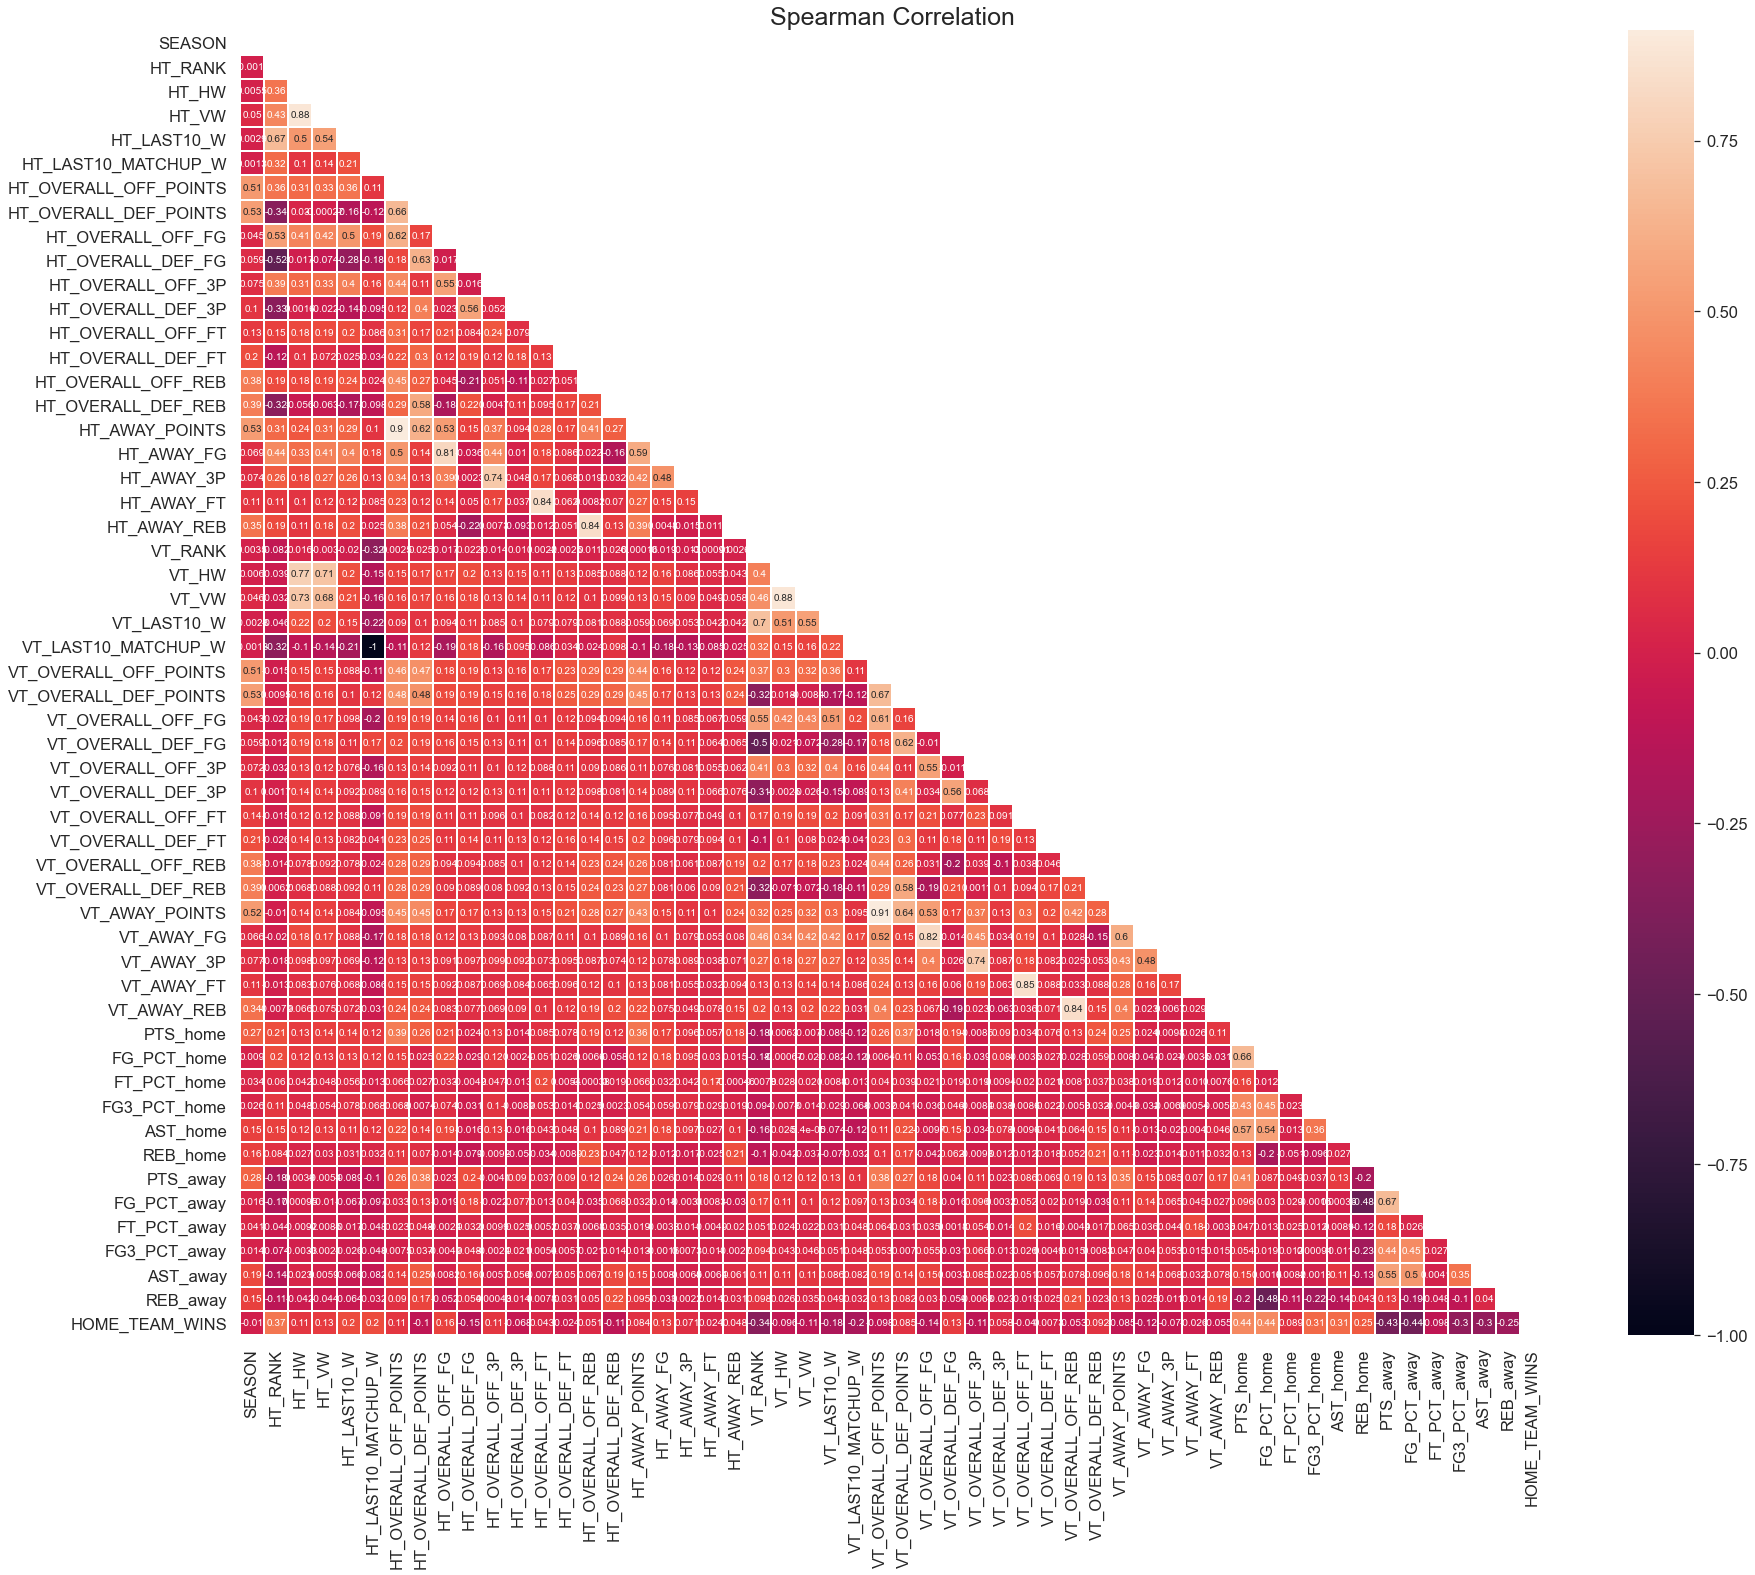

In [24]:
save_heatmap(plot_heatmap(spearman_corr, "Spearman Correlation"), "spearman_corr")

In [25]:
top_corr_features_df = top_corr_features(spearman_corr)
qgrid_widget = qgrid.show_grid(top_corr_features_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

### __Kendall correlation__

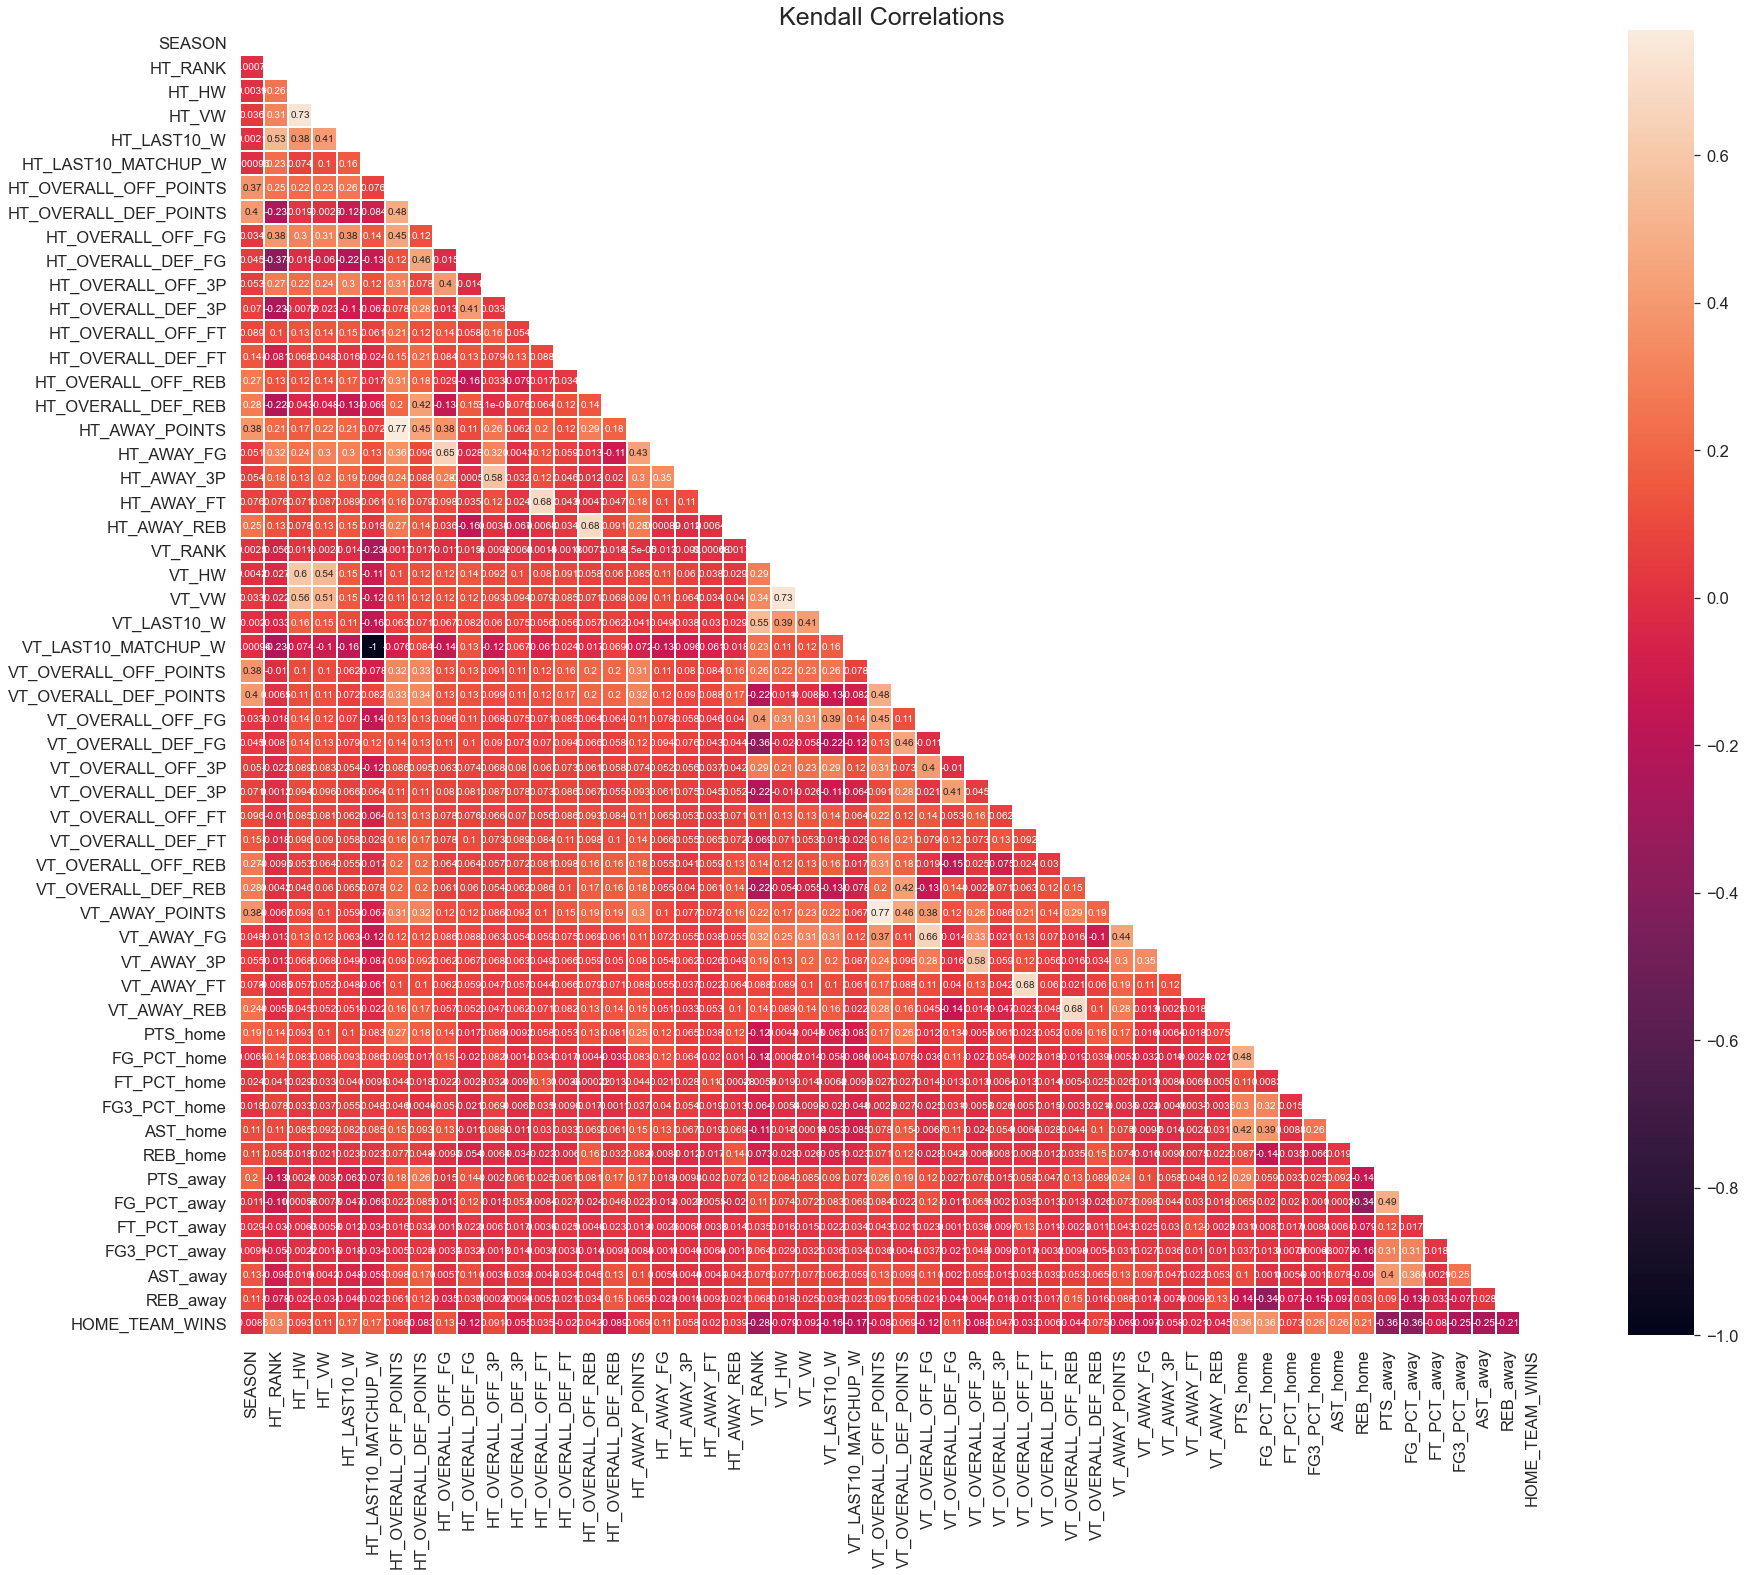

In [26]:
save_heatmap(plot_heatmap(kendall_corr, "Kendall Correlations"), "kendall_corr")

In [27]:
top_corr_features_df = top_corr_features(kendall_corr)
qgrid_widget = qgrid.show_grid(top_corr_features_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## Generate Panda Profiling Report

In [28]:
profile = ProfileReport(df, title='Pandas Profiling Report', pool_size=4,
                        minimal=True,
                        explorative=True,
                           correlations={
             "pearson": {"calculate": True},
             "spearman": {"calculate": True},
             "kendall": {"calculate": True},
             "phi_k": {"calculate": False},
             "cramers": {"calculate": False},
         })

In [29]:
profile.to_file("plots/pandas_profiling_report.html")
profile

Para visualizar el reporte generado puede acceder a este link:

[Panda Profiling Report](plots/pandas_profiling_report.html)

## Generate sweetviz report

In [30]:
#analyzing the dataset
report = sv.analyze(df)
#display the report
report.show_html('plots/sweetviz_report.html')

:FEATURES DONE:                    |█████████████████████| [100%]   00:19  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:01  -> (00:00 left)


Creating Associations graph... DONE!
Report plots/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


Para visualizar el reporte generado puede acceder a este link:

[Sweetviz](plots/sweetviz_report.html)

## Visualization of correlation between dependent variable and features

In [31]:
#target = df[config.y_columns]
target = df["HOME_TEAM_WINS"]
features = df.drop(config.y_columns, axis=1)

### Drop categorical values

In [32]:
#features.drop(["HT_RANK", "HT_CLASS", "VT_RANK", "VT_CLASS"], axis=1, inplace=True)

In [33]:
features_names = list(features.columns)

## Yellowbrick Visualizer

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


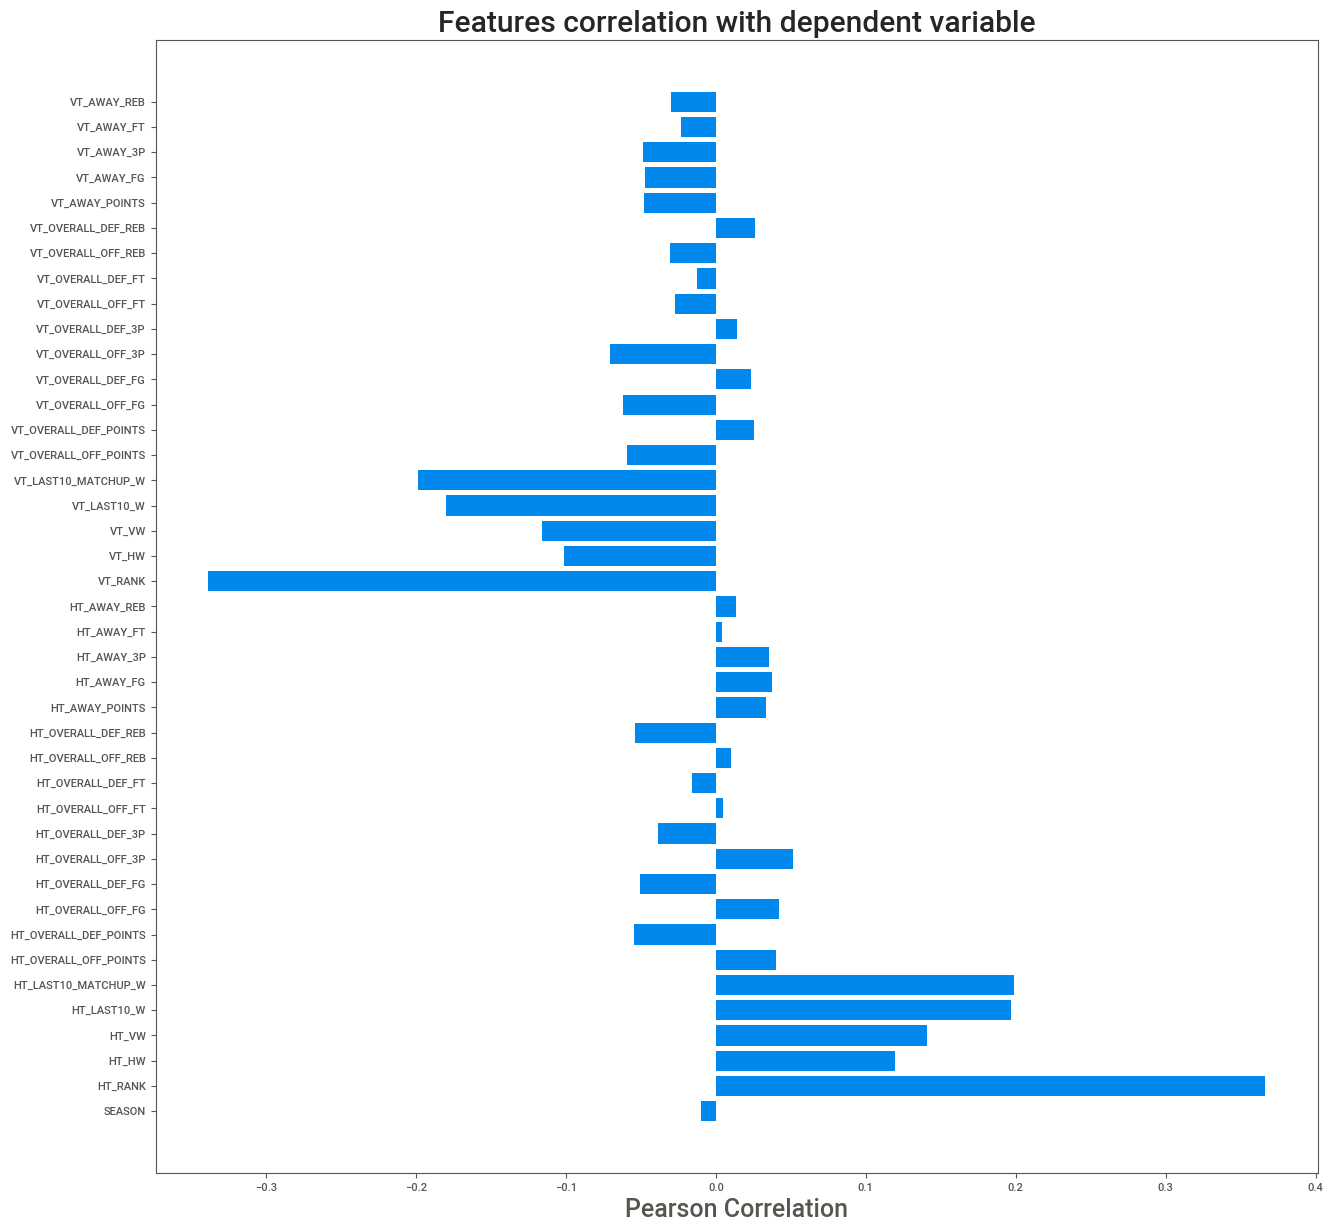

In [34]:
plt.figure(figsize = (15, 15))
visualizer = FeatureCorrelation(labels=features_names)
visualizer.fit(features, target)
visualizer.poof()